# Exploratory Data Analysis

In this notebook, the effects venue types and distances to the nearest urban center, aiport and train station in Perth Suburbs are qualitatively analyzed.

The better rendered notebook can be viewed [here](https://nbviewer.jupyter.org/github/xc-liu/Venue-Types-House-Prices-Relationsip/blob/master/Notebooks/EDA.ipynb) on Jupyter nbviewer.

## Table of Contents

1. [Load the data](#section1)
2. [Cluster and profile the suburbs by their venues](#section2)<br>
    2.1 [Cluster the suburbs](#section2.1)<br>
    2.2 [Profile the suburbs](#section2.2)<br>
3. [Venue categories - house prices relationship](#section3)
4. [Explore the role distance plays in the house prices](#section4)
5. [Mark the suburbs on the map](#section5)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

plt.style.use('ggplot')

### 1. Load the data <a id='section1'></a>
Load the data cleaned in Data_Wrangling.ipynb notebook.

In [2]:
perth_suburbs = pd.read_csv('../Data/Perth_Suburbs.csv', index_col=0)
perth_suburbs.head()

,Suburb,Medium House Price,Growth Percentage,Latitude,Longitude,Nearest Urban Center,Nearest Airport,Nearest Train Station
0,Alexander Heights,430000,3.6,-31.828,115.867,14.0,16.0,7.0
1,Alfred Cove,805000,5.2,-32.034,115.809,10.0,18.0,3.7
2,Alkimos,400000,-1.5,-31.629,115.688,40.0,43.0,8.3
3,Applecross,1600000,0.0,-32.016,115.836,7.0,15.0,2.0
4,Ardross,1050000,0.0,-32.025,115.841,7.9,15.0,2.2


In [3]:
perth_suburbs.shape

(301, 8)

We have 301 suburbs' medium house prices, growth percentage, latitude, longitude, and distances to the nearest urban center, the nearest aiport, and the nearest train station. 

Because of the lack of information of the venue changes in the suburbs over the past year, the growth percentages of the medium house prices won't be analyzed in this study.

In [4]:
perth_venues = pd.read_csv('../Data/Perth_Venues.csv', index_col=0)
perth_venues.head()

,African Restaurant,Airport,Airport Gate,Airport Terminal,American Restaurant,Animal Shelter,Apres Ski Bar,Aquarium,Arcade,Art Gallery,...,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo
Suburb,,,,,,,,,,,,,,,,,,,,,
Alexander Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alfred Cove,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alkimos,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Applecross,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ardross,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
perth_venues.shape

(297, 281)

In [6]:
# get a description of the numbers of venue types of the suburbs
(perth_venues > 0).sum(axis=1).describe()

count    297.000000
mean      18.542088
std       13.807035
min        1.000000
25%        7.000000
50%       15.000000
75%       27.000000
max       60.000000
dtype: float64

We have 297 suburbs' venue data, with 281 categories of venues in total. There are between 1 and 60 venue types for each suburb, with 18.54 being the average number.

These two dataframes have information of different numbers of suburbs. This is Foursquare API didn't find venue information for some of the suburbs. In this study, we'll only use suburbs with found venue information. 

In [7]:
# drop the suburbs without venue data
perth_suburbs = perth_suburbs[perth_suburbs['Suburb'].isin(perth_venues.index)]
perth_suburbs.shape

(297, 8)

### 2. Cluster and profile the suburbs by their venues <a id='section2'></a>

First, let's get at the most common 10 venues in each suburb.

#### Cluster the suburbs <a id='section2.1'></a>

Because there are only 150 venues maximun pulled for each suburbs, and that there are 281 venue categories in total, there are only a small number of venues of each category pulled for each suburb in this dataframe, and a small inaccuracy of these numbers may result in a bigger inaccuracy when clustering the suburbs.

Thus, instead of clustering the suburbs based on the venue categories shown above, I am going to merge some of the categories together first to reduce the error, and then cluster the suburbs based on the new venue categories.

In [8]:
# create a dataframe of the original venue categories and the new venue categories
venue_categories = pd.DataFrame()
venue_categories['Name'] = list(perth_venues.columns)

In [9]:
# create lists of keywords for different new categories
Food_kw = ['buffet', 'food', 'restaurant', 'bakery', 'chicken', 'wings joint', 'café', 'cafe', 'soup', 'salad', 'sandwich', 'pizza', 'bbq', 'diner', 'steak', 'noodle', 'deli', 'bistro', 'burrito', 'burger', 'breakfast', 'taco', 'snack', 'butcher', 'bagel', 'chocolate', 'donut', 'cupcake', 'dessert', 'chips', 'yogurt', 'pastry', 'pie', 'sausage', 'creperie']
Beverage_kw = ['tea', 'coffee']
Automotive_kw = ['auto', 'gas station']
Store_kw = ['store', 'shop', 'boutique', 'market', 'grocery', 'plaza', 'retailer']
Transport_kw = ['airport', 'bus', 'train', 'transportation', 'rail', 'track', 'metro', 'intersection', 'heliport', 'platform', 'moving target', 'tram']
Arts_kw = ['art', 'museum', 'opera', 'music', 'concert', 'exhibit', 'historic', 'library', 'cultur', 'planetarium', 'sculpture', 'memorial']
Bank_kw = ['bank', 'atm']
Alcohol_kw = ['bar', 'pub', 'nightclub', 'speakeasy', 'wine', 'beer']
Sports_kw = ['rink', 'ski', 'rugby', 'surf', 'gym', 'sports', 'tennis', 'soccer', 'weight loss', 'yoga', 'pool', 'skating', 'golf', 'ball', 'outdoors', 'bowling', 'bike', 'hockey']
Nature_kw = ['camp', 'tree', 'nature', 'zoo', 'aquarium', 'garden', 'river', 'park', 'lookout', 'nightlife', 'mountain', 'forest', 'lake', 'fountain', 'landscap']
Coast_kw = ['waterfront', 'beach', 'pier', 'harbor', 'boat', 'lighthouse']
Office_kw = ['office', 'agency', 'department']
Recreation_kw = ['casino', 'entertainment', 'vacation', 'theater', 'circus', 'comedy', 'play', 'recreation', 'arcade', 'newsstand', 'game', 'multiplex', 'radio']
Education_kw = ['school', 'college']
Religion_kw = ['church']
Healthcare_kw = ['pharmacy', 'doctor', 'medical', 'chiropractor', 'hospital']
Animal_kw = ['pet', 'dog', 'cat', 'animal']
Service_kw = ['information', 'service', 'cleaner', 'salon', 'tattoo', 'spa', 'massage', 'repair', 'currency', 'locksmith', 'laundromat', 'tailor']
Storage_kw = ['storage', 'warehouse']
Studio_kw = ['studio']
Social_kw = ['social', 'club', 'community center']
Lodge_kw = ['hotel', 'motel', 'hostel', 'bed', 'resort']
Factory_kw = ['factory', 'distillery', 'brewery']
Structure_kw = ['building', 'neighborhood', 'canal', 'bridge', 'stadium', 'housing']
Farm_kw = ['farm', 'vineyard', 'stable']
Rest_kw = ['rest', 'lounge']

for i in range(len(venue_categories)):
    name = venue_categories.loc[i, 'Name']
    l_name = name.lower()
    
    # if the name of the original category match any of these keywords, it will be assigned a new category
    if any(word in l_name for word in Food_kw):
        category = 'Food'
    elif any(word in l_name for word in Beverage_kw):
        category = 'Beverage'
    elif any(word in l_name for word in Alcohol_kw):
        category = 'Alcohol'
    elif any(word in l_name for word in Automotive_kw):
        category = 'Automotive'
    elif any(word in l_name for word in Transport_kw):
        category = 'Transport'
    elif any(word in l_name for word in Nature_kw):
        category = 'Nature'
    elif any(word in l_name for word in Education_kw):
        category = 'Education'
    elif any(word in l_name for word in Arts_kw):
        category = 'Arts'
    elif any(word in l_name for word in Bank_kw):
        category = 'Banking'
    elif any(word in l_name for word in Sports_kw):
        category = 'Sports'
    elif any(word in l_name for word in Coast_kw):
        category = 'Coast'
    elif any(word in l_name for word in Recreation_kw):
        category = 'Recreation'
    elif any(word in l_name for word in Animal_kw):
        category = 'Animal'
    elif any(word in l_name for word in Store_kw):
        category = 'Store'
    elif any(word in l_name for word in Office_kw):
        category = 'Office'
    elif any(word in l_name for word in Religion_kw):
        category = 'Religion'
    elif any(word in l_name for word in Healthcare_kw):
        category = 'Healthcare'
    elif any(word in l_name for word in Service_kw):
        category = 'Service'
    elif any(word in l_name for word in Storage_kw):
        category = 'Storage'
    elif any(word in l_name for word in Studio_kw):
        category = 'Studio'
    elif any(word in l_name for word in Social_kw):
        category = 'Social'
    elif any(word in l_name for word in Lodge_kw):
        category = 'Lodge'
    elif any(word in l_name for word in Factory_kw):
        category = 'Factory'
    elif any(word in l_name for word in Structure_kw):
        category = 'Structure'
    elif any(word in l_name for word in Farm_kw):
        category = 'Farm'
    elif any(word in l_name for word in Rest_kw):
        category = 'Rest'
    else:
        category = name
    
    # pass the new category name back to the dataframe
    venue_categories.loc[i, 'Category'] = category
    
venue_categories.T

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
Name,African Restaurant,Airport,Airport Gate,Airport Terminal,American Restaurant,Animal Shelter,Apres Ski Bar,Aquarium,Arcade,Art Gallery,...,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo
Category,Food,Transport,Transport,Transport,Food,Animal,Alcohol,Nature,Recreation,Arts,...,Farm,Nature,Coast,Alcohol,Alcohol,Alcohol,Alcohol,Food,Sports,Nature


In [10]:
# check the venue categories that didn't get new names
venue_categories.query('Name == Category')

,Name,Category
89,Farm,Farm
97,Food,Food
181,Office,Office


All original categories have corresponding new categories now. It's time to replace the original venue categories with the new ones.

In [11]:
# get the transpose of perth_venues dataframe
perth_venues_categories = perth_venues.T.reset_index()
# replace the original venue category names with the new ones
perth_venues_categories.loc[:,'index'] = venue_categories.loc[:,'Category']
# group the dataframe by the new venue categories and transpose it back
perth_venues_categories = perth_venues_categories.groupby('index').sum().T
perth_venues_categories.columns.name = ''

perth_venues_categories.head()

,Alcohol,Animal,Arts,Automotive,Beverage,Coast,Education,Factory,Farm,Food,...,Office,Recreation,Rest,Service,Social,Sports,Store,Structure,Studio,Transport
Suburb,,,,,,,,,,,,,,,,,,,,,
Alexander Heights,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.384615,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.461538,0.000000,0.0,0.000000
Alfred Cove,0.021739,0.0,0.021739,0.021739,0.021739,0.000000,0.0,0.0,0.0,0.608696,...,0.0,0.000000,0.000000,0.0,0.0,0.021739,0.195652,0.021739,0.0,0.000000
Alkimos,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.600000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.200000,0.200000,0.0,0.000000
Applecross,0.066667,0.0,0.044444,0.022222,0.022222,0.022222,0.0,0.0,0.0,0.444444,...,0.0,0.022222,0.022222,0.0,0.0,0.022222,0.177778,0.000000,0.0,0.022222
Ardross,0.057692,0.0,0.057692,0.019231,0.019231,0.019231,0.0,0.0,0.0,0.461538,...,0.0,0.019231,0.019231,0.0,0.0,0.019231,0.211538,0.000000,0.0,0.000000


To determine the best number of clusters for kMeans clustering, F-test score and p-value are used here, since the number that results in the most significant difference among different clusters' medium house prices would be the most ideal.

In [12]:
def kMeans_anova(X, Y, k):  
    # assure that dataframe X and Y have the same length
    assert(len(X) == len(Y))
    
    # cluster X
    kmeans = KMeans(init='k-means++', n_clusters=k, max_iter=100, n_init=1, verbose=0, random_state=3425)
    kmeans.fit(X)
    
    # create a dataframe of Y values combined with the cluster labels of Y (same as that of X)
    y_anova = Y.copy()
    y_anova['Cluster Label'] = kmeans.labels_

    # get all the Y values for different clusters
    groups = []
    for y, group in y_anova.groupby('Cluster Label'):
        groups.append(group[Y.columns[0]])

    # calculate the F-test score and the p-value 
    anova_results = f_oneway(*groups)
    
    # return the F-test score and the p-value
    return anova_results

In [13]:
# calculate the F-test scores and p-values for different numbers of clusters
for i in range(2, 7):
    anova_results = kMeans_anova(perth_venues_categories, perth_suburbs[['Medium House Price']], i)
    print(i, ":\n", anova_results)

2 :
 F_onewayResult(statistic=12.798608213055326, pvalue=0.00040529789842911826)
3 :
 F_onewayResult(statistic=21.70473443671686, pvalue=1.6141334422326197e-09)
4 :
 F_onewayResult(statistic=15.178868213684312, pvalue=3.303110931674446e-09)
5 :
 F_onewayResult(statistic=7.1743383290696485, pvalue=1.599933072844596e-05)
6 :
 F_onewayResult(statistic=8.838364840557066, pvalue=7.970312798678373e-08)


As shown above, 3 clusters are the best to cluster the suburbs into, with the most significant difference among the clusters (F-test score), and a reasonable degree of confidence (pvalue).

In [14]:
# cluster the suburbs into 3 clusters based on their venue categories
kmeans = KMeans(init='k-means++', n_clusters=3, max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(perth_venues_categories)
suburb_labels = kmeans.labels_
suburb_labels

array([2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       0, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 1,
       2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2,
       0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2,
       1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1,
       2, 1, 2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 2,
       0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2,
       2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 2, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 0, 0,
       1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1])

***
#### Profile the suburbs <a id='section2.2'></a>

Now that we have all the labels for suburbs, let's have a look at the most common venue categories in different clusters.

In [15]:
perth_venues_categories['Cluster Label'] = suburb_labels

In [16]:
perth_venues_categories[perth_venues_categories['Cluster Label']==0].describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Nature,49.0,0.220555,0.197753,0.0,0.066667,0.2,0.333333,1.000000
Store,49.0,0.206576,0.180044,0.0,0.000000,0.2,0.307692,0.500000
Alcohol,49.0,0.109378,0.217102,0.0,0.000000,0.0,0.142857,1.000000
Sports,49.0,0.083277,0.133286,0.0,0.000000,0.0,0.142857,0.500000
Transport,49.0,0.074811,0.135414,0.0,0.000000,0.0,0.125000,0.500000
Food,49.0,0.070818,0.094216,0.0,0.000000,0.0,0.166667,0.250000
Lodge,49.0,0.044898,0.165594,0.0,0.000000,0.0,0.000000,1.000000
Farm,49.0,0.042371,0.109364,0.0,0.000000,0.0,0.000000,0.500000
Coast,49.0,0.031388,0.094800,0.0,0.000000,0.0,0.000000,0.500000


In [17]:
perth_venues_categories[perth_venues_categories['Cluster Label']==1].describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Cluster Label,134.0,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000
Food,134.0,0.505087,0.099848,0.25,0.444444,0.500000,0.559286,0.800000
Store,134.0,0.164930,0.071331,0.00,0.118848,0.175439,0.214286,0.312500
Alcohol,134.0,0.063815,0.053993,0.00,0.020944,0.057418,0.092495,0.250000
Nature,134.0,0.046687,0.047558,0.00,0.000000,0.037386,0.071429,0.250000
Sports,134.0,0.044543,0.045344,0.00,0.000000,0.035714,0.066667,0.250000
Beverage,134.0,0.034466,0.037585,0.00,0.000000,0.027402,0.060624,0.222222
Transport,134.0,0.022895,0.044263,0.00,0.000000,0.000000,0.022222,0.250000
Arts,134.0,0.020224,0.031805,0.00,0.000000,0.000000,0.031622,0.250000


In [18]:
perth_venues_categories[perth_venues_categories['Cluster Label']==2].describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Cluster Label,114.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Store,114.0,0.357438,0.110190,0.142857,0.285714,0.346990,0.400000,1.000000
Food,114.0,0.321603,0.101583,0.000000,0.272727,0.337719,0.390700,0.571429
Sports,114.0,0.058277,0.067314,0.000000,0.000000,0.044949,0.089610,0.300000
Nature,114.0,0.052965,0.055414,0.000000,0.000000,0.045455,0.083333,0.250000
Automotive,114.0,0.032633,0.054958,0.000000,0.000000,0.000000,0.043247,0.285714
Arts,114.0,0.027742,0.044571,0.000000,0.000000,0.000000,0.044729,0.250000
Alcohol,114.0,0.024013,0.035747,0.000000,0.000000,0.000000,0.038280,0.142857
Beverage,114.0,0.022574,0.037170,0.000000,0.000000,0.000000,0.040000,0.200000


**The first cluster** is the closest to the nature, also features stores and alcohol. It has the smallest ratio of food venues (restaurants, etc.), but the largest ratios of alcohol venues (including pubs and breweries), lodges and transport venues (possibly because there are more transient population and less permanent population than the other clusters). It's also big on sports (possibly because the land is cheaper, which is good for building sports venues). Unlike the other two, it has little education venues, offices or social clubs, but with about 10 times more farms and 5 times more studios.

**The second cluster** has more than half venues being food venues, which is the largest among the three, with stores being its second most popular venue category, the ratio of which is nevertheless the lowest compared to the other two clusters. It has the lowest ratios of sports venues and nature venues. Unlike the other two, this cluster has more alcohol venues than nature venues. It's also the only cluster that has a decent amount of social clubs.

**The third cluster** features stores and food, with a decent ratio of sports and nature venues. It has no farms, the smallest ratio of alcohol venues and lodge venues, but the largest ratio of education venues among the three clusters. It also has the most pet related venues, healthcare venues (including hospitals and pharmacies), and automotive venues (including gas stations and auto garages).

Let's have a look at the most commen 10 venues of the suburbs in every cluster to double check these profiles.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_sorted = row.sort_values(ascending=False)
    
    return row_sorted.index.values[:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = []
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns, index=perth_venues.index)

for ind in np.arange(perth_venues.shape[0]):
    suburbs_venues_sorted.iloc[ind, :] = return_most_common_venues(perth_venues.iloc[ind, :], num_top_venues)

suburbs_venues_sorted['Cluster Label'] = suburb_labels

suburbs_venues_sorted.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label
Suburb,,,,,,,,,,,
Alexander Heights,Fast Food Restaurant,Pizza Place,Grocery Store,Park,Liquor Store,Skate Park,Sandwich Place,Shopping Mall,Flea Market,Supermarket,2
Alfred Cove,Fast Food Restaurant,Café,Sandwich Place,Chinese Restaurant,Park,Japanese Restaurant,Portuguese Restaurant,Supermarket,Grocery Store,Indian Restaurant,1
Alkimos,Fast Food Restaurant,Housing Development,Supermarket,American Restaurant,Flower Shop,Farmers Market,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,1
Applecross,Café,Park,Grocery Store,Japanese Restaurant,Department Store,Pub,Portuguese Restaurant,Beach,Coffee Shop,Gas Station,1
Ardross,Café,Park,Department Store,Grocery Store,Japanese Restaurant,Supermarket,Electronics Store,Pub,Fast Food Restaurant,Shopping Mall,1


In [21]:
# return most common venues in the 1st cluster
suburbs_venues_sorted[suburbs_venues_sorted['Cluster Label']==0]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label
Suburb,,,,,,,,,,,
Aubin Grove,Park,Shopping Mall,Train Station,Bar,Supermarket,Grocery Store,Fast Food Restaurant,Falafel Restaurant,Farm,Farmers Market,0
Beckenham,Park,Seafood Restaurant,Arts & Crafts Store,Electronics Store,Grocery Store,Pharmacy,Train Station,Gym / Fitness Center,Furniture / Home Store,Fish & Chips Shop,0
Beeliar,Grocery Store,Brewery,Hockey Rink,Electronics Store,Gift Shop,Toy / Game Store,Park,Boat or Ferry,Food,Flower Shop,0
Bickley,Vineyard,Gift Shop,Yoga Studio,Winery,Café,Zoo,Farm,Farmers Market,Fast Food Restaurant,Fireworks Store,0
Boya,Park,Jewelry Store,Theater,Scenic Lookout,Ski Lodge,Bar,Candy Store,Dance Studio,Flea Market,Fish Market,0
Brabham,Playground,Fruit & Vegetable Store,Pharmacy,Athletics & Sports,Park,Zoo,Fireworks Store,Farm,Farmers Market,Fast Food Restaurant,0
Bullsbrook,Coffee Shop,Bar,Memorial Site,Grocery Store,Zoo,Fast Food Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,0
Carmel,Vineyard,Winery,Garden,Flea Market,Farm,Farmers Market,Fast Food Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,0
Casuarina,Hobby Shop,Farmers Market,Pub,Home Service,Golf Course,Zoo,Farm,Fast Food Restaurant,Fireworks Store,Fish & Chips Shop,0


The suburbs in the first cluster indeed have lots of parks, playgrounds, zoos, and also wineries, vineyards and breweries. They seem to be pretty relaxed suburbs that are close to the nature and farms. They make lots of wine as well.

In [22]:
# return most common venues in the 2nd cluster
suburbs_venues_sorted[suburbs_venues_sorted['Cluster Label']==1]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label
Suburb,,,,,,,,,,,
Alfred Cove,Fast Food Restaurant,Café,Sandwich Place,Chinese Restaurant,Park,Japanese Restaurant,Portuguese Restaurant,Supermarket,Grocery Store,Indian Restaurant,1
Alkimos,Fast Food Restaurant,Housing Development,Supermarket,American Restaurant,Flower Shop,Farmers Market,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,1
Applecross,Café,Park,Grocery Store,Japanese Restaurant,Department Store,Pub,Portuguese Restaurant,Beach,Coffee Shop,Gas Station,1
Ardross,Café,Park,Department Store,Grocery Store,Japanese Restaurant,Supermarket,Electronics Store,Pub,Fast Food Restaurant,Shopping Mall,1
Armadale,Fast Food Restaurant,Brazilian Restaurant,Video Game Store,Big Box Store,Bus Station,Café,Shopping Mall,Electronics Store,Auto Garage,Sandwich Place,1
Ascot,Hotel,Fast Food Restaurant,Pizza Place,Motel,Pharmacy,Racetrack,Beer Store,Café,Tea Room,Gastropub,1
Ashby,Gym,Park,Bakery,Trail,Seafood Restaurant,Café,Lake,Falafel Restaurant,Farm,Farmers Market,1
Attadale,Café,Park,Fast Food Restaurant,Liquor Store,Shopping Mall,Grocery Store,Indian Restaurant,Stadium,Sports Club,Scenic Lookout,1
Baldivis,Fast Food Restaurant,Sandwich Place,Café,Grocery Store,Farm,Farmers Market,Fireworks Store,Fish & Chips Shop,Fish Market,Zoo,1


Restaurants are definately a big part of the second cluster. It also has lots of parks, though not as many as the other two clusters.

In [23]:
# return most common venues in the 3rd cluster
suburbs_venues_sorted[suburbs_venues_sorted['Cluster Label']==2]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label
Suburb,,,,,,,,,,,
Alexander Heights,Fast Food Restaurant,Pizza Place,Grocery Store,Park,Liquor Store,Skate Park,Sandwich Place,Shopping Mall,Flea Market,Supermarket,2
Ashfield,Coffee Shop,Pub,Fast Food Restaurant,Park,Grocery Store,Sandwich Place,Train Station,Fish Market,Fish & Chips Shop,Supermarket,2
Atwell,Café,Grocery Store,Portuguese Restaurant,Juice Bar,Gas Station,Electronics Store,Shopping Mall,Mexican Restaurant,Big Box Store,Chinese Restaurant,2
Aveley,Café,Grocery Store,Fast Food Restaurant,Coffee Shop,Park,Liquor Store,Health & Beauty Service,Bookstore,Supermarket,Shopping Mall,2
Balcatta,Pizza Place,Café,Grocery Store,Supermarket,Liquor Store,Shop & Service,Electronics Store,Gas Station,Fast Food Restaurant,Big Box Store,2
Balga,Grocery Store,Gym / Fitness Center,Pizza Place,Electronics Store,Supermarket,Coffee Shop,Plaza,Dessert Shop,Fast Food Restaurant,Skating Rink,2
Ballajura,Fast Food Restaurant,Electronics Store,Pet Store,Sandwich Place,Grocery Store,Pharmacy,Supermarket,Furniture / Home Store,Skating Rink,Shopping Mall,2
Banksia Grove,Fast Food Restaurant,Park,Pet Store,Supermarket,Golf Course,Shopping Plaza,Event Space,Falafel Restaurant,Farm,Farmers Market,2
Bassendean,Pub,Park,Café,Grocery Store,Supermarket,Train Station,Tapas Restaurant,Gourmet Shop,Wine Bar,Bakery,2


Same as the second cluster, the suburbs in the third cluster have lots of restaurants, cafés, but it seems to have more grocery stores, shopping malls and pet stores.

Next, let's have a look at the boxplots of each cluster's prices. The venue data and the suburb data will be merged for convenience.

In [24]:
# merge the venue data and suburb data
perth_suburbs_venues = pd.concat(
    [perth_suburbs[['Suburb', 'Medium House Price', 'Nearest Urban Center', 'Nearest Airport', 'Nearest Train Station']].set_index('Suburb'),
     perth_venues], axis=1, join='inner')

perth_suburbs_venues['Cluster Label'] = suburb_labels
perth_suburbs_venues.head()

,Medium House Price,Nearest Urban Center,Nearest Airport,Nearest Train Station,African Restaurant,Airport,Airport Gate,Airport Terminal,American Restaurant,Animal Shelter,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo,Cluster Label
Suburb,,,,,,,,,,,,,,,,,,,,,
Alexander Heights,430000,14.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Alfred Cove,805000,10.0,18.0,3.7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Alkimos,400000,40.0,43.0,8.3,0.0,0.0,0.0,0.0,0.2,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Applecross,1600000,7.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Ardross,1050000,7.9,15.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Text(0.5, 0.98, '')

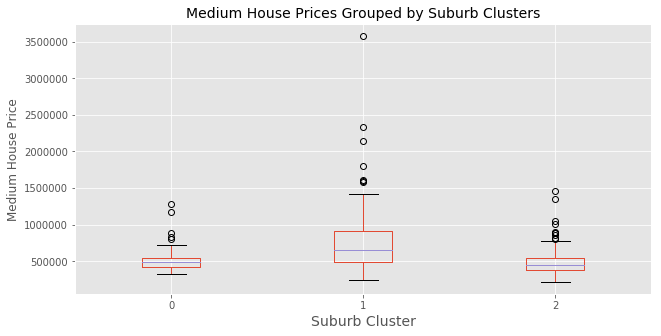

In [25]:
# plot boxplots of the prices in each cluster
boxplot = perth_suburbs_venues.boxplot(column='Medium House Price', by='Cluster Label', figsize=(10, 5))
boxplot.set_title('Medium House Prices Grouped by Suburb Clusters', fontsize=14)
boxplot.set_xlabel('Suburb Cluster', fontsize=14)
boxplot.set_ylabel('Medium House Price')
plt.suptitle('')

As shown in the boxplots above, the suburbs in Cluster 1 (the second cluster) has the highest mean of medium house prices, about $700,000, and the widest price range. 

Cluster 2 (the third cluster) has the lowest price mean, just less than $500,000, but its price range is larger than Cluster 0, with its third quartile value slightly larger than that of Cluster 0.

The mean price of Cluster 0 (the first cluster) is very close to $500,000. This cluster has the smallest price range.

The differences in house prices among different clusters here are reflected by the differences in the ratios of venue categories in the suburbs. 

### 3.Venue categories - house prices relationship <a id='section3'></a>

Next, let's have a look at how some of the venue categories affect / indicate the house prices.

Because the degree of dispersion of the prices is not consistent for different ratios of a venue category, it's not a good idea to use linear models here to describe the relationship between the price and the ratio. Instead, it would be better to group the ratios in bins first, and then explore how the price mean and price standard deviation are influenced by the change of the ratio mean of the group.

In [26]:
def binning_variables(variables, prices, kbins): # define a function to bin variables
    assert(len(variables) == len(prices)) # to assure variables and prices have the same length
    
    bins = np.linspace(variables.min(), variables.max(), kbins+1)
    labels = list(range(kbins))
    
    # create a dataframe of the variables, their corresponding prices, and their labels after binning
    df = pd.DataFrame()
    df['Variable'] = variables
    df['Price'] = prices
    df['Binned'] = pd.cut(df['Variable'], bins=bins, labels=labels)
    
    # group the dataframe by the labels of bins and calculate the means, stds and counts of each bin
    means = df.groupby('Binned', sort=True).mean() # create a dataframe of the means in the order of bin labels
    stds = df.groupby('Binned', sort=True).std() # create a dataframe of the stds of in the order of bin labels
    stds.fillna(0, inplace=True) # replace NaN with 0 in the stds dataframe
    counts = df.groupby('Binned', sort=True).count() # create a dataframe of the counts in the order of bin labels
    
    # convert the dataframes into lists
    variable_means = np.array(means['Variable'])
    price_means = np.array(means['Price'])
    price_stds = np.array(stds['Price'])
    suburb_counts = np.array(counts['Variable'])

    # return variable means, price means, price standard deviations, and the numbers of suburbs
    return variable_means, price_means, price_stds, suburb_counts

In [27]:
def venue_vs_price(venue_name): # define a function to plot price-venue_ratio plot for a venue category
    # create a dataframe of the ratios of a venue type and their corresponding medium house prices
    venue_name = venue_name.title()
    venues = perth_venues_categories[[venue_name]].copy()
    venues['Price'] = list(perth_suburbs['Medium House Price'])
    
    ksuburbs = (venues[[venue_name]] > 0).sum()[0] # calculate the number of suburbs that have this venue category
    kbin = int(ksuburbs / 15) # initiate a number of bins for binning
    v_suburb_counts = [0] # initiate a list of numbers of suburbs
    
    # while there are any bins with 0 suburbs, subtract the number of bins by one until there are no greater than 3 bins left. 
    while 0 in v_suburb_counts:
        if kbin <= 3: # skip plotting if the number of bins is not greater than 3, because if the number is no more than 3,
            return # the range of ratios would be so small that the errors when trying to find its relationship with prices would be too big.
        v_ratio_means, v_price_means, v_price_stds, v_suburb_counts = binning_variables(venues[venue_name], venues[['Price']], kbin)
        kbin -= 1
    
    # skip plotting if there are only less than 3 bins with more than 3 suburbs, because the trend of the price curve would be too susceptible to errors then
    if sum(v_suburb_counts > 3) < 3:
        return
    
    # plot the price means, price deviations, and number of suburbs on the same figur with the number of suburbs curve being orange
    figure = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax1 = ax.twinx()
    ax.plot(v_ratio_means, v_price_means, label='Price Mean')
    ax.plot(v_ratio_means, v_price_stds, label='Price Standard Deviation')
    ax1.plot(v_ratio_means, v_suburb_counts, label='Suburb Numbers', color='orange')
    
    for x, y in zip(v_ratio_means, v_suburb_counts):
        ax1.annotate('(%.2f, %s)' % (x, y), xy=(x, y+1), textcoords='data') 
    
    ax.set_title('Relationship between Ratio of {} Venues and Medium House Price in a Suburb'.format(venue_name), fontsize=14)
    ax.set_xlabel('Ratio of {} Venues ({} bins)'.format(venue_name, kbin), fontsize=14)
    ax.set_ylabel('Medium House Price', fontsize=14)
    ax1.set_ylabel('Number of Suburbs', fontsize=14, color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')

    ax.legend(loc='upper right', fontsize=14)
    ax1.legend(loc='lower left', fontsize=14)

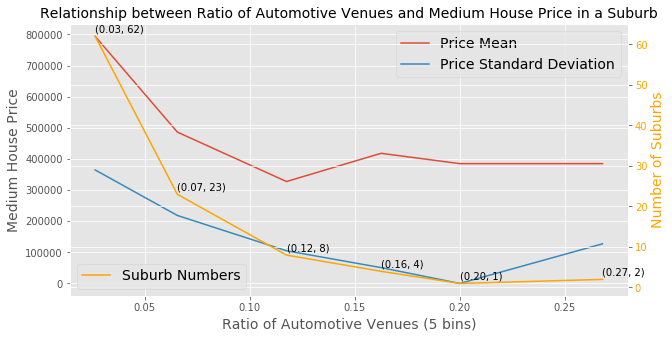

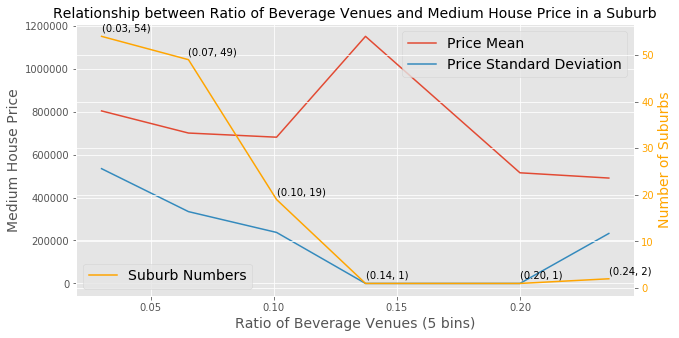

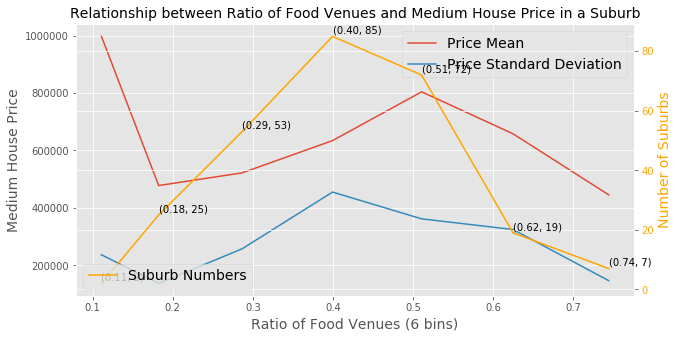

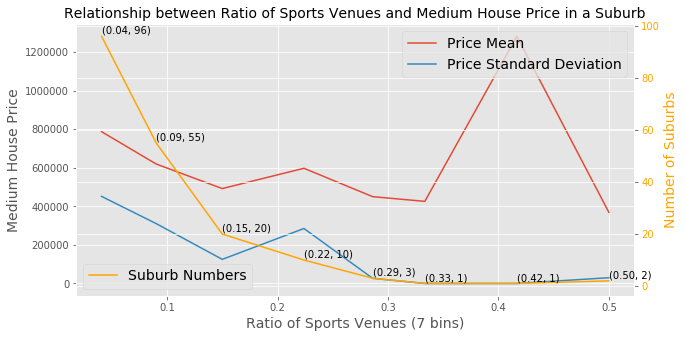

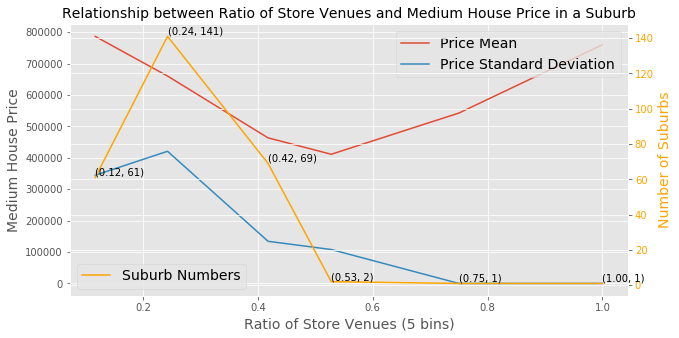

In [28]:
for venue in perth_venues_categories.columns[:-1]:
    # plot only venue vategories with more than 30 suburb samples to reduce errors
    if (perth_venues_categories[[venue]] > 0).sum()[0] > 30:
        venue_vs_price(venue)

There are figures of 5 venue categories plotted above.

**The Automotive category** includes mainly gas stations and auto garages. The figure shows that most of the suburbs have less than 8% venues in this category. Within this range, the more Automotive venues there are in the suburbs, the lower their mean medium house price is, and lower the price standard deviation is. From 8% to 15%, this declining trend is slower, with fewer suburbs in the sample. After 15%, the number of suburbs is too small to make any meaningful conclusion out of it.

**The Beverage category** includes all venue categories that have the keyword "tea" or "coffee". Most of the suburbs have less than 10% of their venues being beverage venues. Between 0% and 10%, the higher the ratio of beverage venues is, the more concentrated the medium house prices are around a lower mean value. After 10%, the sample size is so small that the change of prices is more likely due to the influence of other categories.

**The Food category** includes venues that mainly sell food. All suburbs have at least 10% venues being in this category, with most of them having 18% to 62%. There are a very small number of suburbs in the first bin with only 10% Food venues but a very high price mean, and we can't be sure how big a role the Food venues play in this high price, so it's better to leave it out in this analysis. From around 18% on, the mean price of the medium house prices grows, peaks at 51%, and then declines. The price standard deviation grows as the ratio increases from 18% to 40%, and then declines.

**The Sports category** includes gyms and venues used for sports. In the figure, the price mean and price standard deviation decline slowly as the ratio of sports venues increases from 4% to 15%, the range of which nearly all suburbs are in, and then both increase slightly until the ratio reaches 22%. After 22%, the sample size is too small to show any meaningful trends.

**The Store category** includes all the supermarkets, markets, stores, malls, etc, the ratio of which is around 24% for most of the suburbs. In all the bins with good amounts of suburbs, the price mean declines as the ratio grows from 12% to 42%, while the price standard deviation rises first before declines, with its peak at 24%.

### 4. Explore the role distance plays in the house prices <a id='section4'></a>

Distances to the nearest urban center, aiport and train station are very influential in determining house prices. Will they affect house prices differently in different suburb clusters? Next, we are going to have a look at the relationship between these distances and house prices in every suburb cluster, and also in all suburbs together.

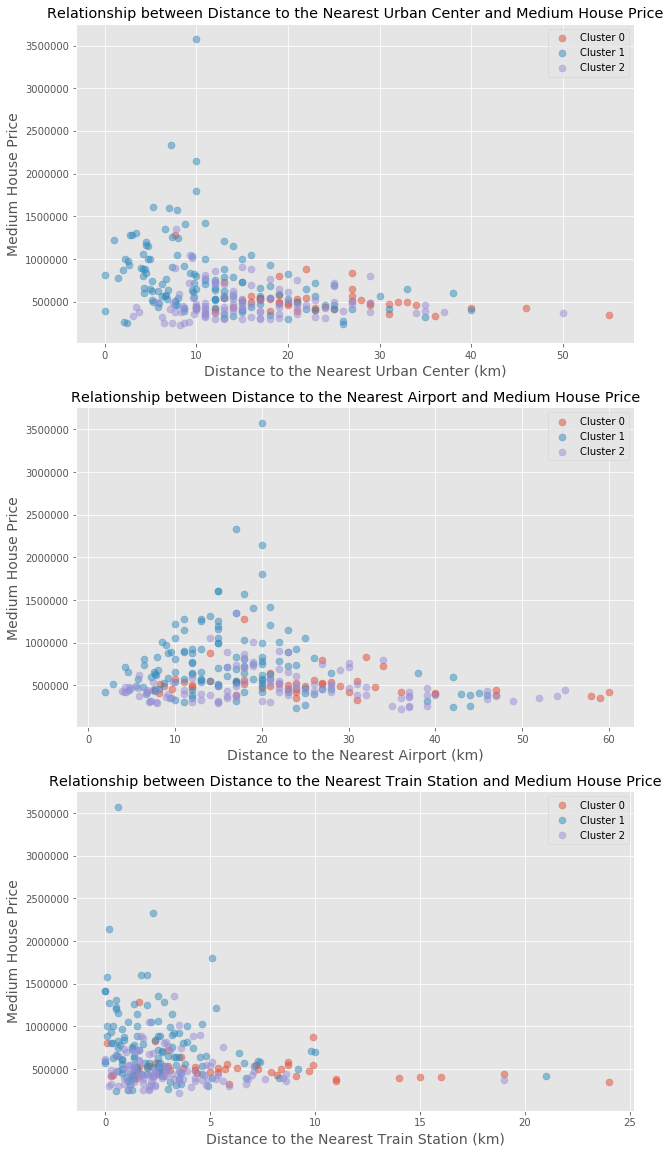

In [29]:
fig = plt.figure(figsize=(10,20))
ax0 = plt.subplot(311)
ax1 = plt.subplot(312)
ax2 = plt.subplot(313)

kcluster = 3
s = 50
alpha = 0.5
names = ['Nearest Urban Center', 'Nearest Airport', 'Nearest Train Station']

# plot scatterplots, with points from different cluster having different colors
for name, ax in zip(names, [ax0, ax1, ax2]):
    for i in range(kcluster):
        cluster = perth_suburbs_venues[perth_suburbs_venues['Cluster Label'] == i]
        ax.scatter(cluster[name], cluster['Medium House Price'], label='Cluster {}'.format(i), s=s, alpha=alpha)
        
    ax.set_xlabel('Distance to the {} (km)'.format(name), fontsize=14)
    ax.set_ylabel('Medium House Price', fontsize=14)
    ax.legend(loc='best')
    ax.set_title('Relationship between Distance to the {} and Medium House Price'.format(name))

Same as when dealing with the venue category ratio data and price data, the degree of dispersion of the prices is not consistent for different distances, making it hard for regression models to make sense. The same method of binning variables and then plotting the means and standard deviations of the prices would be suitable here.

In [30]:
# create a dataframe for every suburb cluster
suburb_group0 = perth_suburbs_venues[perth_suburbs_venues['Cluster Label'] == 0].copy()
suburb_group1 = perth_suburbs_venues[perth_suburbs_venues['Cluster Label'] == 1].copy()
suburb_group2 = perth_suburbs_venues[perth_suburbs_venues['Cluster Label'] == 2].copy()

for suburb_group in [suburb_group0, suburb_group1, suburb_group2]:
    suburb_group.dropna(axis=0, how='any', inplace=True)

print("There are {} suburbs in cluster 0, {} in cluster 1, {} in cluster 2.".format(len(suburb_group0), len(suburb_group1), len(suburb_group2)))

There are 47 suburbs in cluster 0, 132 in cluster 1, 106 in cluster 2.


In [31]:
def binning_distances_plot(suburbs, c_label=''):
    def binning_name_plot(name, ax):
        kbins = int(len(suburbs) / 5) # initiate the number of bins
        counts = [0] # initiate the list of numbers of suburbs
        
        # bin the distances into the minimum number of bins that allows every bin to have at least 1 suburb
        while 0 in counts:
            dist_means, price_means, price_stds, counts = binning_variables(suburbs['{}'.format(name)], 
                                                                            suburbs['Medium House Price'],
                                                                            kbins)
            kbins -= 1
        
        ax.plot(dist_means, price_means, label='Price Means')
        ax.plot(dist_means, price_stds, label='Price Standard Deviation')
        ax.set_title('Price Means and Price Standard Deviation for Binned Distances to the {}'.format(name), fontsize=14)
        ax.set_xlabel('Distance to the {} (km) ({}) ({} Bins)'.format(name, c_label, kbins), fontsize=14)
        ax.set_ylabel('House Price', fontsize=14)
        ax.legend(loc='upper right', fontsize=14)
        
        ax1 = ax.twinx()
        ax1.plot(dist_means, counts, label='Number of Suburbs', color='orange')
        ax1.legend(loc='upper right', fontsize=14)
        ax1.set_ylabel('Number of Suburbs', color='orange', fontsize=14)
        ax1.tick_params(axis='y', labelcolor='orange')
        ax1.legend(loc='lower left', fontsize=14)
        
        prev_y = -1
        adjust = 0.5
        for x, y in zip(dist_means, counts):
            if y == prev_y: # prevent the annotations from overlapping
                adjust = -adjust
                adj = adjust
            else:
                adj = 0.1
            ax1.annotate('(%.f, %s)' % (x, y), xy=(x, y + adj), textcoords='data', fontsize=10) 
            prev_y = y
    
    
    uc = 'Nearest Urban Center'
    ap = 'Nearest Airport'
    st = 'Nearest Train Station'
    
    fig = plt.figure(figsize=(13,25))
    ax_uc = plt.subplot(311)   
    ax_ap = plt.subplot(312)
    ax_ts = plt.subplot(313)
    
    for name, ax in zip([uc, ap, st], [ax_uc, ax_ap, ax_ts]):
        binning_name_plot(name, ax)

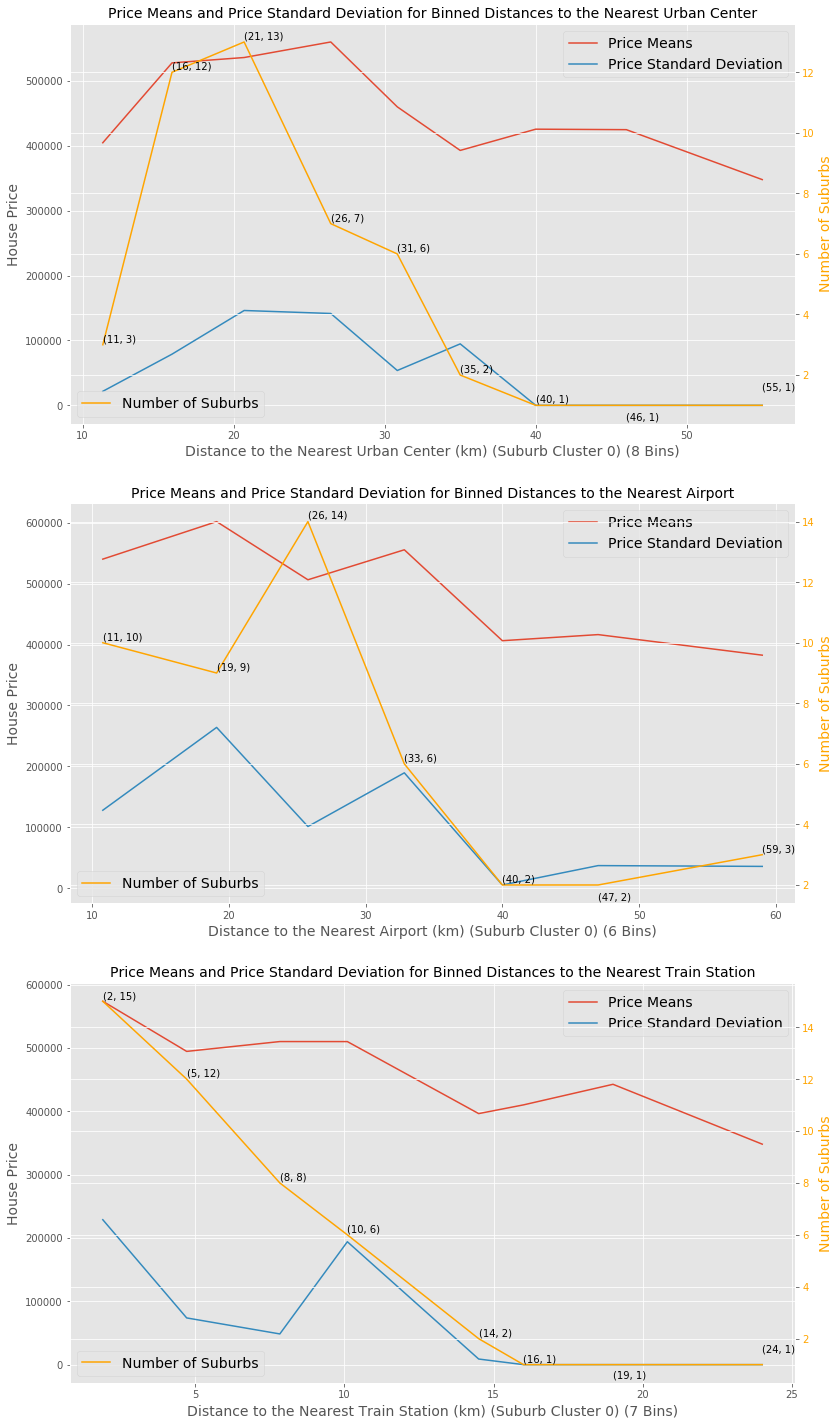

In [32]:
# plot the suburbs in the first cluster
binning_distances_plot(suburb_group0, 'Suburb Cluster 0')

Most of the suburbs in the first cluster are 16 to 31 km away from their nearest urban centers, 11 to 33 km away from their nearest airports, and no more than 10 km away from their nearest train station. 

Their medium house prices mean is the highest when between 16 to 31 km away from the urban centers, or 11 to 33 km away from aiports, along with the largest price ranges. The suburbs with distances to their nearest train station being around 2 km or 10 km have the highest medium house price mean, and also the largest price range.

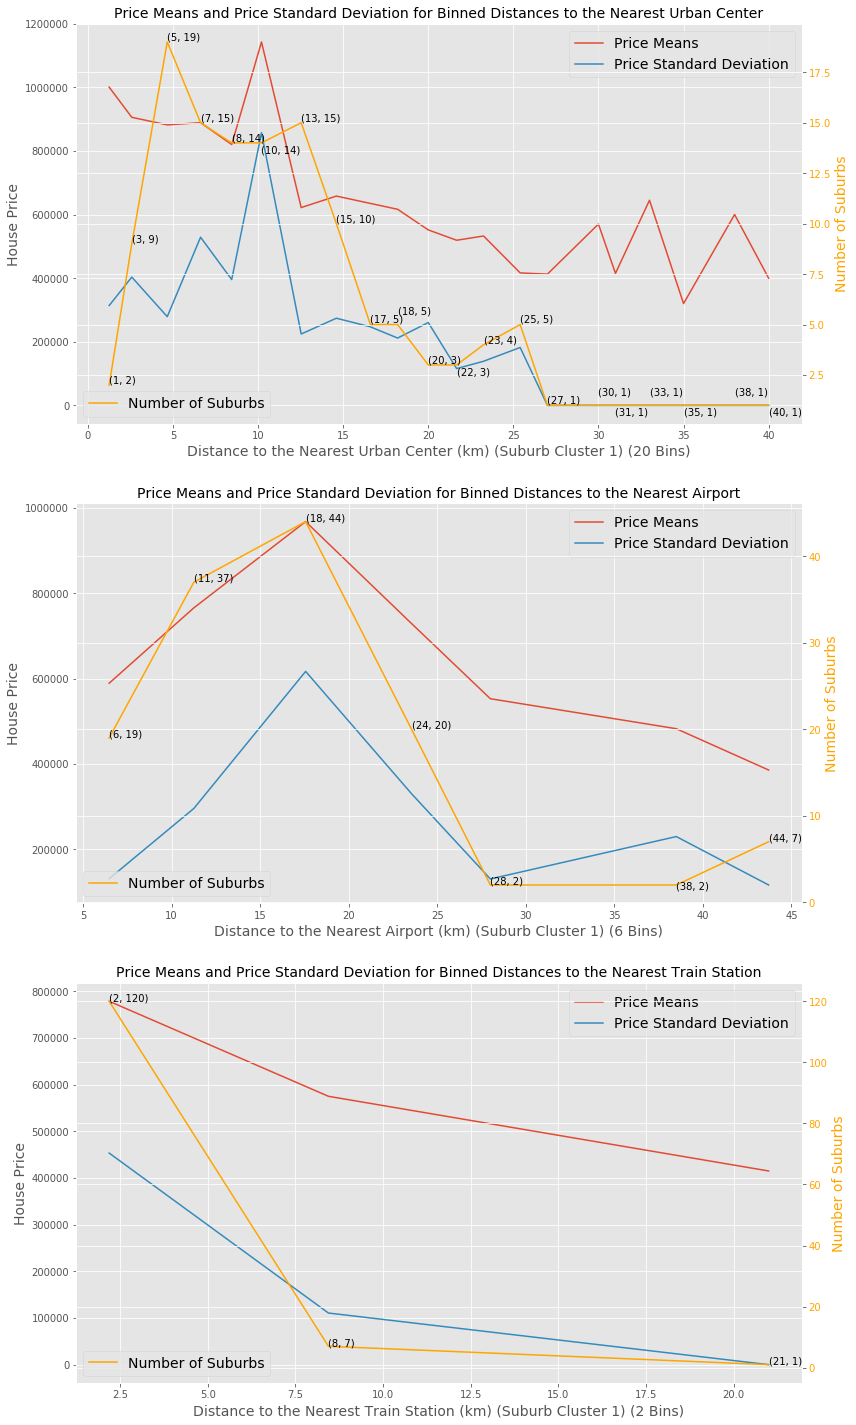

In [33]:
# plot the suburbs in the second cluster
binning_distances_plot(suburb_group1, 'Suburb Cluster 1')

Most of the suburbs in the second cluster are 3 to 15 km away from their nearest urban centers and 6 to 24 km away from their nearest airport. Almost all of them are around 2 km away from their nearest train stations.

The average medium house price and price standard deviation are both the highest when the suburbs are around 10 km from their nearest urban centers, 18 km from their nearest airports, or 2 km from their nearest train stations.

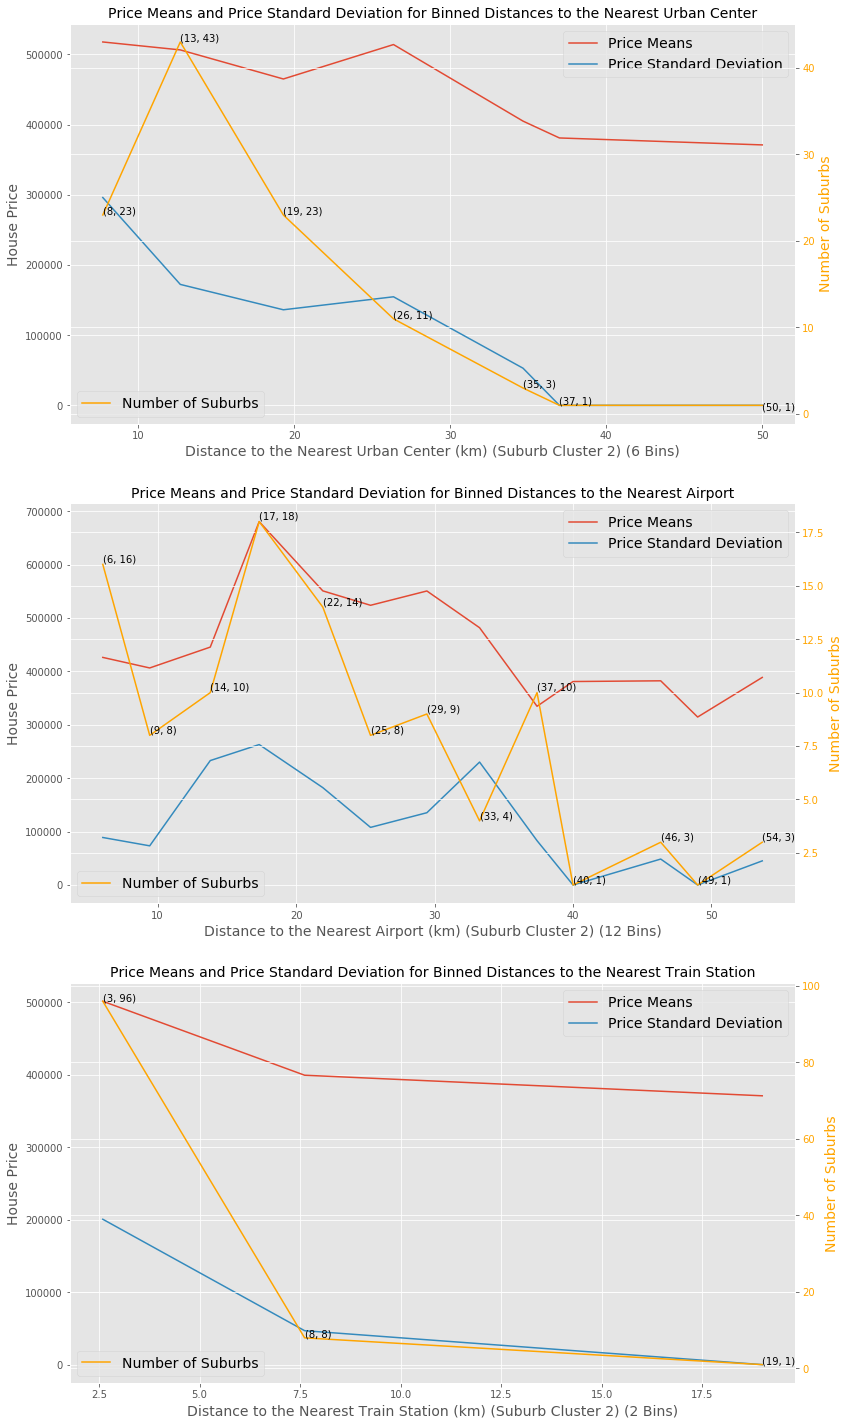

In [34]:
binning_distances_plot(suburb_group2, 'Suburb Cluster 2')

Most of the suburbs in the third cluster are 8 to 26 km away from their nearest urban centers, 6 to 37 km away from their nearest airports, and almost all of them are around 3 km away from their nearest train station.

The distance to the nearest urban center doesn't affect the medium house price mean much when it's between 8 to 26 km, with only small flucturation, but the standard deviation does have an overall declining trend. The suburbs that are 14 to 33 km away from their nearest airports have the highest medium house price mean and price deviation, with their peaks both at around 17 km. The average medium house price and the price standard deviation of the suburbs declines when distance to their nearest train station increases.

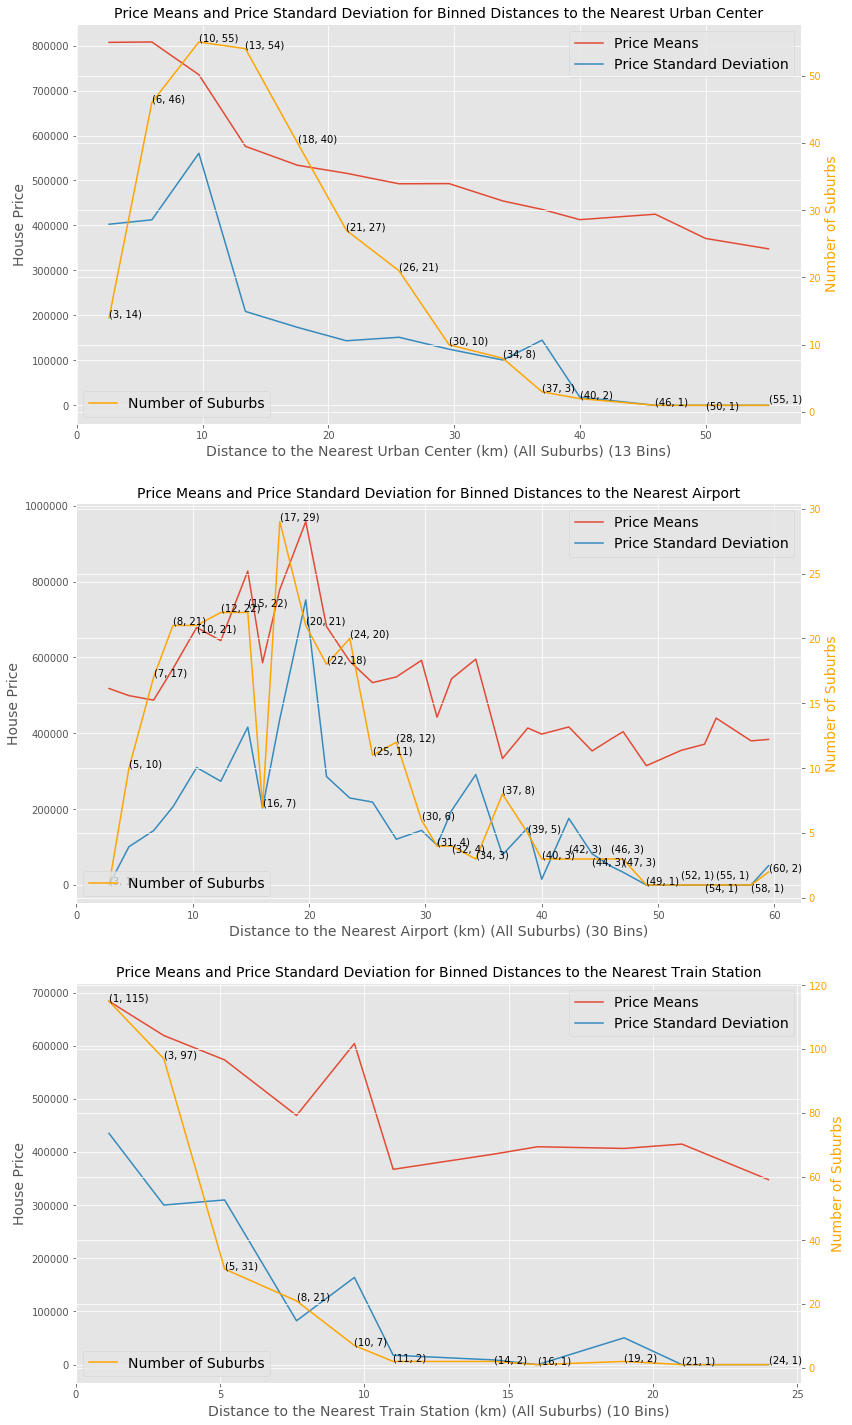

In [35]:
binning_distances_plot(perth_suburbs_venues, 'All Suburbs')

Most of the suburbs in Perth are within 30 km from the urban center, 5 to 28 km away from the airports, and within 8 km from the train stations.

Overall, the mean of the medium house prices of the suburbs declines as the distance to the urban center increases, while the price deviation increases first before it starts to decline after 10 km. The price mean is the highest when the suburbs are 8 to 22 km away from the airports, along with the largest price deviation. Less than 5 km or around 10 km away from the train stations is where you'll find the suburbs with the highest average medium house price, and the price range of the suburbs within 5 km away from the train stations is the largest.

<a id='section5'></a>
### 5. Mark the suburbs on the map

Finally, let's have a look at the suburbs on Perth map with their marker colors showing their medium house price / cluster label.

In [36]:
def numbers_to_colors(arr): # difine a function to convert numbers into color codes
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    
    colors_array = cm.rainbow(arr)
    arr_rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    return arr_rainbow

In [37]:
# convert the prices into color codes
perth_suburbs['Price Color'] = numbers_to_colors(np.array(perth_suburbs['Medium House Price']))
# convert the cluster labels into color codes
perth_suburbs['Cluster Color'] = numbers_to_colors(np.array(perth_suburbs_venues['Cluster Label']))

In [38]:
# make a map of Perth
perth_map = folium.Map(location=[-31.9505, 115.8605], zoom_start=10)

# mark all the suburbs with their colors showing their medium house price
for name, price, lat, lng, color in zip(perth_suburbs['Suburb'], 
                                        perth_suburbs['Medium House Price'], 
                                        perth_suburbs['Latitude'], 
                                        perth_suburbs['Longitude'], 
                                        perth_suburbs['Price Color']):
    folium.CircleMarker([lat, lng], 
                        radius=500, 
                        popup="{}, ${}".format(name, price), 
                        color=color,
                        fill_color=color).add_to(perth_map)
perth_map

In [39]:
# make a map of Perth
perth_map = folium.Map(location=[-31.9505, 115.8605], zoom_start=10)

# mark all the suburbs with their colors showing their cluster labels
for name, price, lat, lng, color, cluster in zip(perth_suburbs['Suburb'], 
                                                 perth_suburbs['Medium House Price'], 
                                                 perth_suburbs['Latitude'], 
                                                 perth_suburbs['Longitude'], 
                                                 perth_suburbs['Cluster Color'], 
                                                 perth_suburbs_venues['Cluster Label']):
    folium.CircleMarker([lat, lng], 
                        radius=500, 
                        popup="{}, Cluster {}, ${}".format(name, cluster, price), 
                        color=color,
                        fill_color=color).add_to(perth_map)
perth_map

As shown in the first map, the suburbs close to the rivers or the coast are generally the suburbs with the highest medium house prices. Interestingly, in the second map, we can see those suburbs are mostly in the second cluster (Cluster 1). The suburbs in the first cluster (Cluster 0) are the farthest from the urban center, with many of them being the farthest from the coast. The third cluster (Cluster 2) suburbs are mostly between the Cluster 1 area and the Cluster 0 area.

It's true that venues can bring changes to the local economy. Also, geological location of a suburb can greatly affect its economy. This difference in the geological distribution of the suburbs from different cluster is probably suggesting that, instead of affecting house prices and local economy, venue types do a better job reflecting the local economy and hence are an indicator of local house prices.

If these assumptions are true, the suburbs in the second cluster (Cluster 1, the green markers in the second map) that have low house prices at the moment (the darker markers in the first map) might be of the most potential to have a growing housing market in 2019.

For more analysis on this study, please refer to my final report. Thank you for reading.